# Imports

In [139]:
import numpy as np
import pandas as pd
import datetime
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate)
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

# Plotting
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
RNG_SEED = 111
np.random.seed(RNG_SEED)

# Extracting a pandas DataFrame from our CSV Data
We want to remove all columns with missing data, but first we have to remove the Precipitation column, because we only care about whether it rains tomorrow, not today.

We'll also replace our date column with a new column of categorical data, specifying if it is the wet season (Oct thru Apr) or the dry season (May thru September)

In [140]:
Weather = pd.read_csv('weather_data.csv')
Weather = Weather.drop('Precipitation', axis='columns')
Weather = Weather.assign(
    WetSeason = pd.Categorical(
        ['Yes' if (date[5] == '1' or int(date[6]) <= 4) else 'No' for date in Weather['Date']],
        categories=['No', 'Yes'])
    ).drop('Date', axis='columns').dropna()
print(Weather.shape)

(2894, 12)


# Simple Exploratory Data Analysis

In [141]:
Weather.describe().T

,count,mean,std,min,25%,50%,75%,max
AvgDryBulbTemp,2894.0,65.566344,6.596063,48.00,61.00,65.00,71.00,86.00
AvgDewPtTemp,2894.0,53.103663,9.239953,14.00,48.00,54.00,60.00,71.00
AvgRelHumidity,2894.0,68.300968,12.399069,19.00,64.00,71.00,76.00,95.00
AvgSeaLevelPressure,2894.0,29.995988,0.102425,29.62,29.93,29.98,30.06,30.41
AvgStationPressure,2894.0,29.964983,0.102790,29.59,29.90,29.95,30.03,30.38
AvgWindSpeed,2894.0,5.462129,1.985172,1.20,4.10,5.40,6.50,19.00
MaxDryBulbTemp,2894.0,71.973739,6.940665,56.00,67.00,72.00,76.00,101.00
MinDryBulbTemp,2894.0,58.649965,7.838731,38.00,53.00,59.00,65.00,78.00
PeakWindSpeed,2894.0,20.033172,4.606268,9.00,17.00,20.00,22.00,52.00
SustainedWindSpeed,2894.0,14.202488,3.379517,7.00,12.00,14.00,15.00,40.00


In [142]:
will_rain = Weather['RainTomorrow'] == 1
yes_rain_data = Weather[will_rain]
no_rain_data = Weather[~will_rain]

yes_rain_data.describe().T

,count,mean,std,min,25%,50%,75%,max
AvgDryBulbTemp,359.0,61.058496,5.225040,48.00,58.00,60.00,63.00,85.00
AvgDewPtTemp,359.0,50.515320,6.541160,29.00,47.00,51.00,54.00,71.00
AvgRelHumidity,359.0,70.880223,10.069292,30.00,66.00,72.00,78.00,95.00
AvgSeaLevelPressure,359.0,29.995181,0.102417,29.62,29.93,30.00,30.07,30.23
AvgStationPressure,359.0,29.963983,0.102964,29.59,29.90,29.97,30.03,30.19
AvgWindSpeed,359.0,6.481616,2.910873,1.90,4.50,6.00,7.90,19.00
MaxDryBulbTemp,359.0,66.431755,5.830492,56.00,63.00,65.00,68.00,94.00
MinDryBulbTemp,359.0,55.139276,5.976919,38.00,51.00,55.00,58.00,75.00
PeakWindSpeed,359.0,22.532033,6.799068,10.00,18.00,21.00,26.00,52.00
SustainedWindSpeed,359.0,16.350975,5.496514,7.00,13.00,15.00,18.00,40.00


In [143]:
no_rain_data.describe().T

,count,mean,std,min,25%,50%,75%,max
AvgDryBulbTemp,2535.0,66.204734,6.521373,49.00,61.00,66.00,71.00,86.00
AvgDewPtTemp,2535.0,53.470217,9.504942,14.00,48.00,55.00,61.00,70.00
AvgRelHumidity,2535.0,67.935700,12.653735,19.00,64.00,71.00,76.00,92.00
AvgSeaLevelPressure,2535.0,29.996103,0.102446,29.64,29.92,29.98,30.06,30.41
AvgStationPressure,2535.0,29.965124,0.102784,29.67,29.90,29.95,30.03,30.38
AvgWindSpeed,2535.0,5.317751,1.770325,1.20,4.10,5.30,6.40,16.50
MaxDryBulbTemp,2535.0,72.758580,6.725133,56.00,68.00,72.00,77.00,101.00
MinDryBulbTemp,2535.0,59.147140,7.944214,38.00,54.00,60.00,66.00,78.00
PeakWindSpeed,2535.0,19.679290,4.084461,9.00,17.00,20.00,22.00,49.00
SustainedWindSpeed,2535.0,13.898225,2.832731,7.00,12.00,14.00,15.00,38.00


# Building a Simple Decision Tree Model

In [144]:
X = Weather.drop('RainTomorrow', axis='columns')
y = np.where(Weather.RainTomorrow == 1,
                    "Yes",
                    "No")
print(X.dtypes)

# Training/Test Split
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X, y, test_size=0.2, random_state=RNG_SEED, stratify=Weather['RainTomorrow'])

model = MS(X_train, intercept=False)
D = model.fit_transform(X_train, y_train)
predictors = list(D.columns)
clf = DTC(criterion='gini',
          max_depth=3,
          random_state=RNG_SEED)
X_train_arr = np.asarray(D)
clf.fit(X_train_arr, y_train)

AvgDryBulbTemp          float64
AvgDewPtTemp            float64
AvgRelHumidity          float64
AvgSeaLevelPressure     float64
AvgStationPressure      float64
AvgWindSpeed            float64
MaxDryBulbTemp          float64
MinDryBulbTemp          float64
PeakWindSpeed           float64
SustainedWindSpeed      float64
WetSeason              category
dtype: object


,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,111
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


# Trying out a Decision Tree built from the full training set

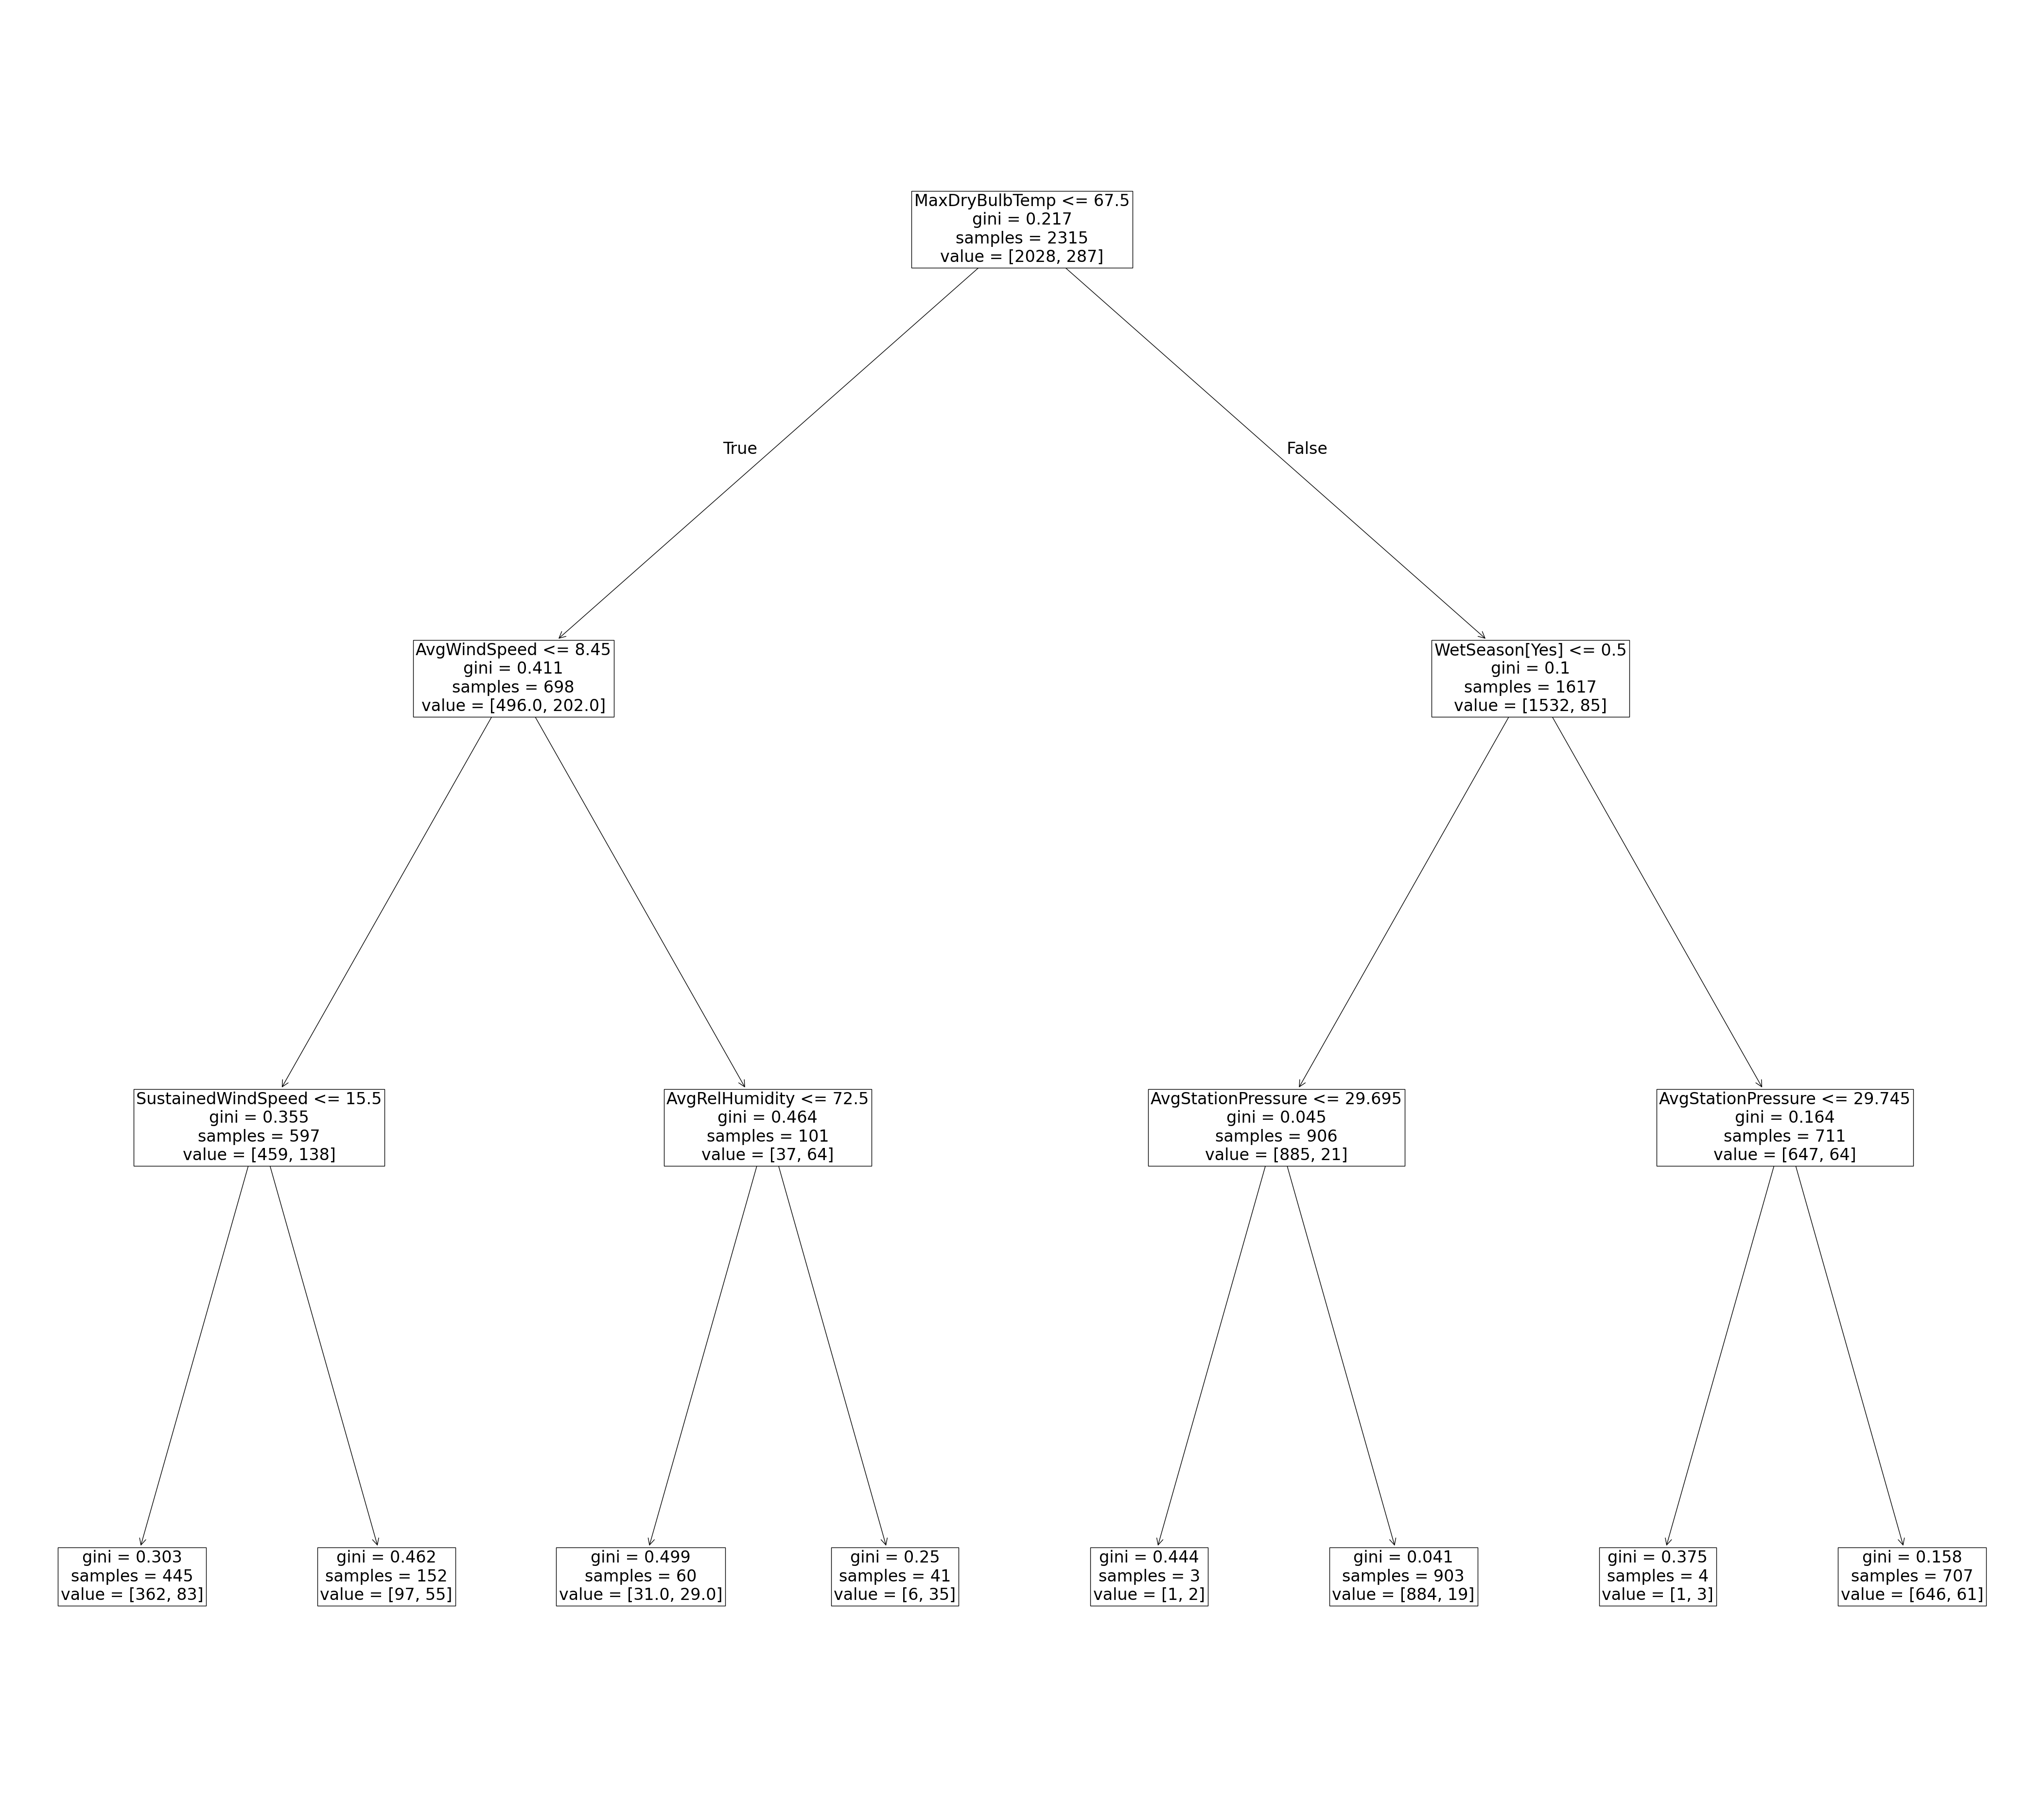

In [145]:
fig, ax = subplots(figsize=(54,48))
plot_tree(clf,
          feature_names=predictors,
          fontsize=24,
          ax=ax)
fig.savefig('fig1.png')

# Using pruning and cross-validation to select optimal tree parameters

Unpruned Model Training Error: 0.0
Naive Bayes Training Error: 0.12419006479481642
Unpruned Model Test Error: 0.17278617710583155
Naive Bayes Test Error: 0.12311015118790491


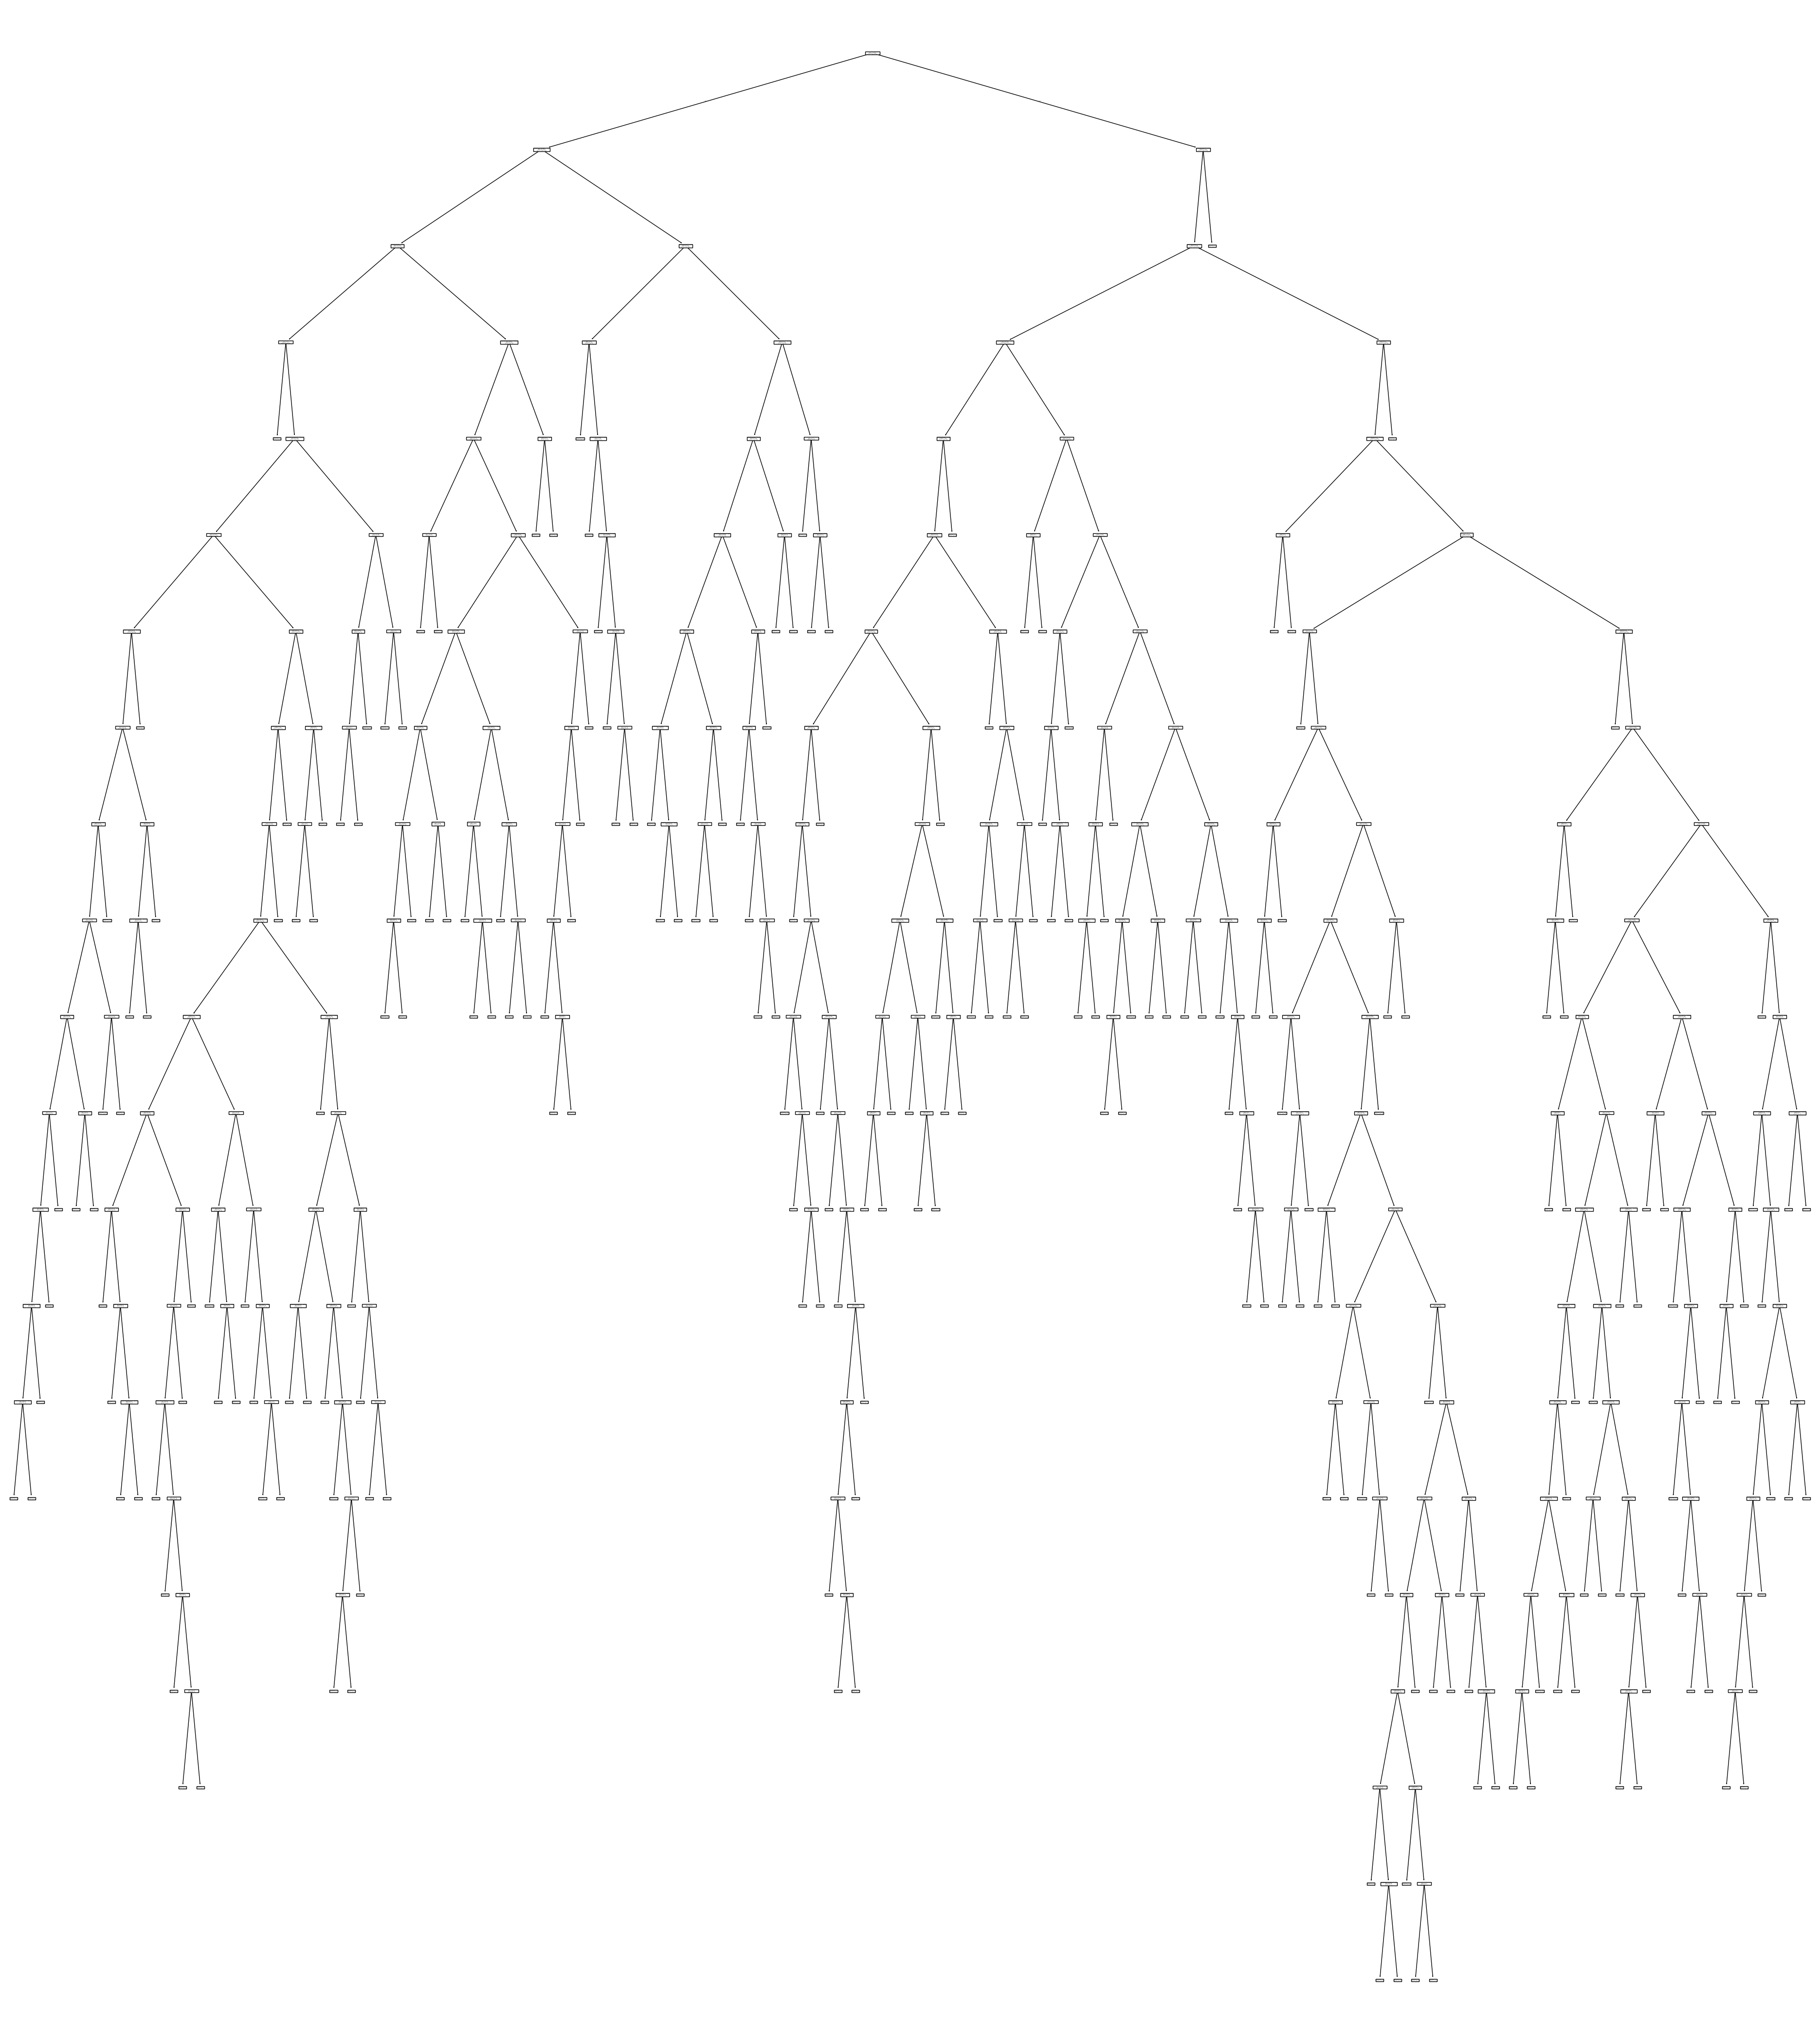

In [165]:
# Further training/test split to avoid using the held-out test set
(X_train1,
 X_test1,
 y_train1,
 y_test1) = train_test_split(X_train_arr, y_train, test_size=0.2, random_state=RNG_SEED+1, stratify=y_train)

clf = DTC(criterion='gini', random_state=RNG_SEED)
clf.fit(X_train1, y_train1)

# Plot the unpruned tree
fig, ax = subplots(figsize=(48,54))
plot_tree(clf,
          feature_names=predictors,
          ax=ax);

fig.savefig("fig6.png")

err_model_train = 1 - accuracy_score(y_train1, clf.predict(X_train1))
err_bayes_train = 1 - accuracy_score(y_train1, ['No'] * len(y_train1))
err_model_test = 1 - accuracy_score(y_test1, clf.predict(X_test1))
err_bayes_test = 1 - accuracy_score(y_test1, ['No'] * len(y_test1))

print("Unpruned Model Training Error: " + str(err_model_train))
print("Naive Bayes Training Error: " + str(err_bayes_train))

print("Unpruned Model Test Error: " + str(err_model_test))
print("Naive Bayes Test Error: " + str(err_bayes_test))

In [164]:
ccp_path = clf.cost_complexity_pruning_path(X_train1, y_train1)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=10,
                        scoring='accuracy')
grid.fit(X_train1, y_train1)

,estimator,DecisionTreeC...dom_state=111)
,param_grid,{'ccp_alpha': array([0. ... 0.02306743])}
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [148]:
print("Best CV Error: " + str(1 - grid.best_score_))

Best CV Error: 0.11769834350479513


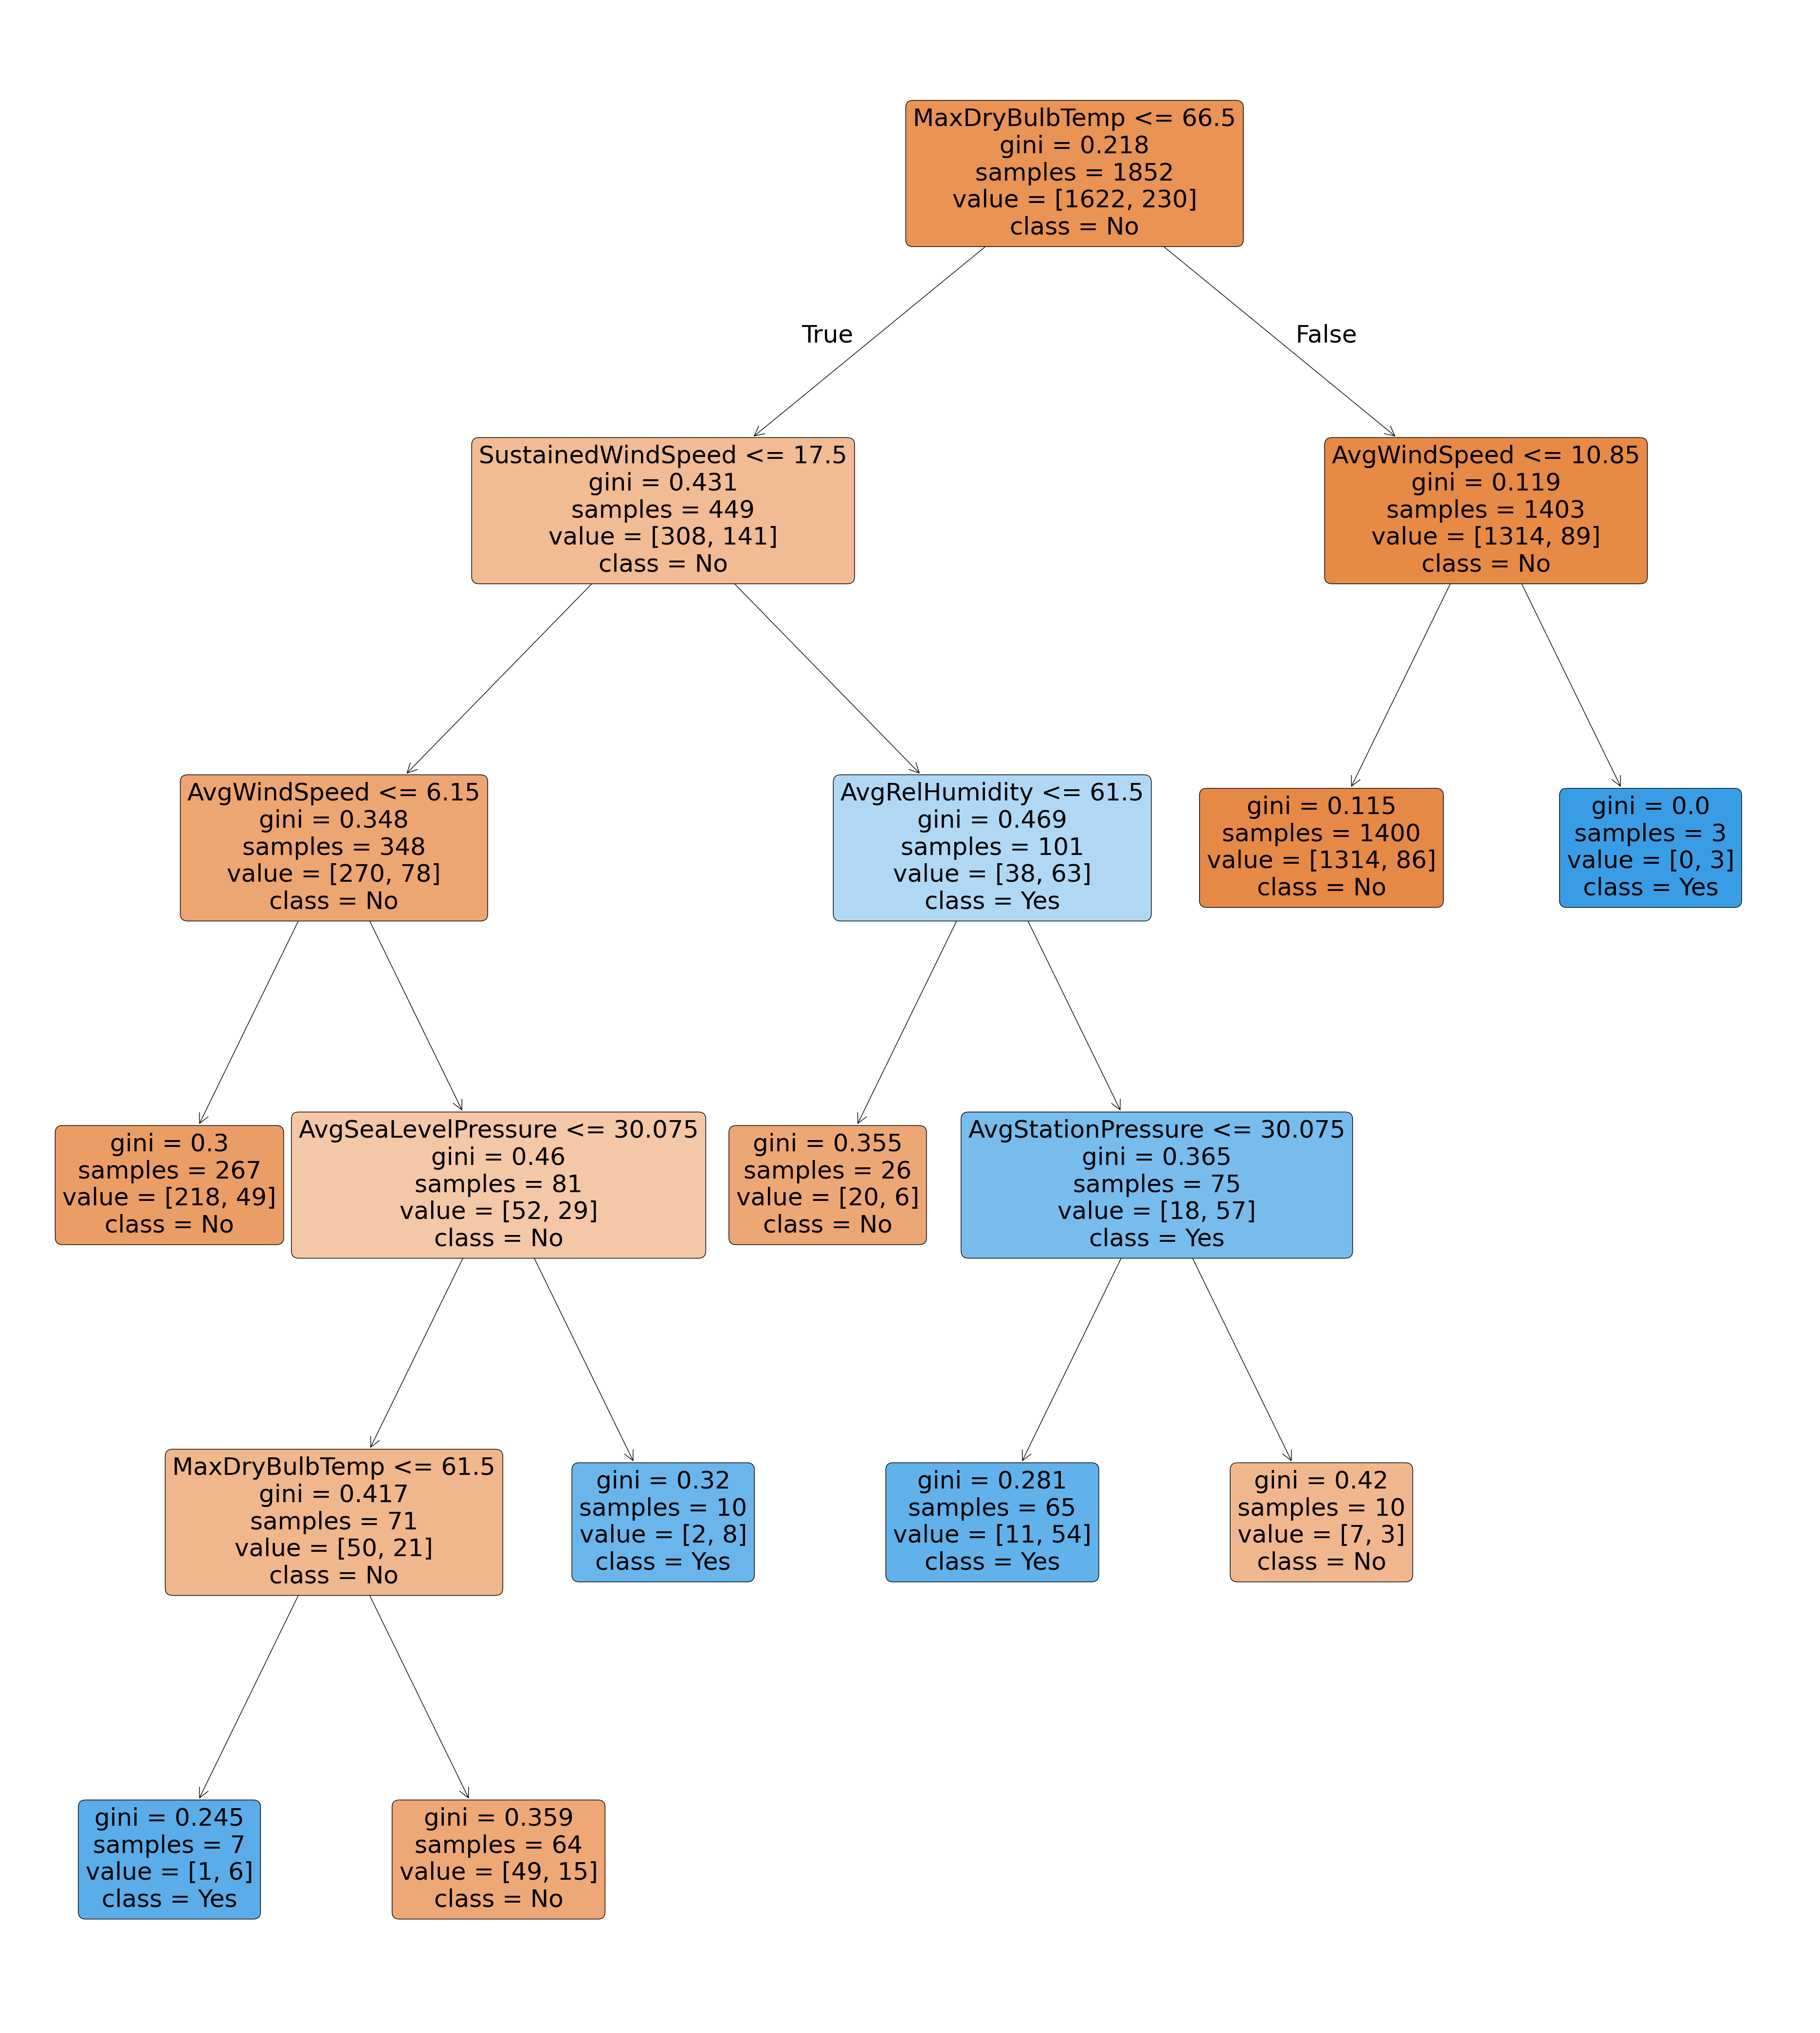

In [149]:
fig, ax = subplots(figsize=(48,54))
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=predictors,
          ax=ax,
          class_names=['No', 'Yes'],
          rounded=True,
          filled=True,
         fontsize=36);
fig.savefig("fig4.png")

In [150]:
err_model_train = 1 - accuracy_score(y_train1, best_.predict(X_train1))
err_bayes_train = 1 - accuracy_score(y_train1, ['No'] * len(y_train1))
err_model_test = 1 - accuracy_score(y_test1, best_.predict(X_test1))
err_bayes_test = 1 - accuracy_score(y_test1, ['No'] * len(y_test1))

print("Pruned Tree Training Error: " + str(1 - accuracy_score(y_train1,
                                       best_.predict(X_train1))))
print("Naive Bayes Training Error: " + str(1 - accuracy_score(y_train1,
                                           ['No'] * len(y_train1))))
print("Pruned Tree Test Error: " + str(1 - accuracy_score(y_test1,
                                       best_.predict(X_test1))))
print("Naive Bayes Test Error: " + str(1 - accuracy_score(y_test1,
                                       ['No'] * len(y_test1))))
confusion = confusion_table(best_.predict(X_test1),
                            y_test1)


confusion

Pruned Tree Training Error: 0.0934125269978402
Naive Bayes Training Error: 0.12419006479481642
Pruned Tree Test Error: 0.11015118790496758
Naive Bayes Test Error: 0.12311015118790491


Truth,No,Yes
Predicted,,
No,396,41
Yes,10,16


# Making a graph of alpha value vs. CV error

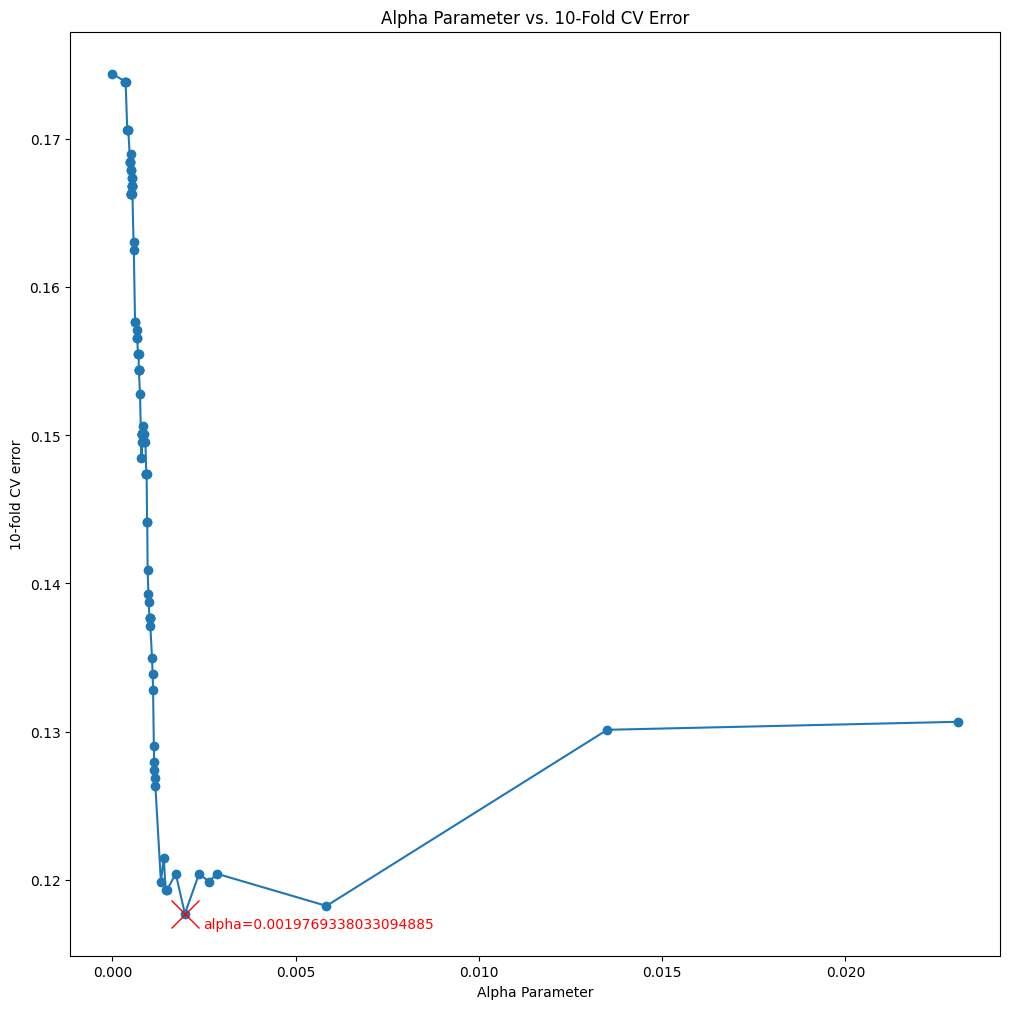

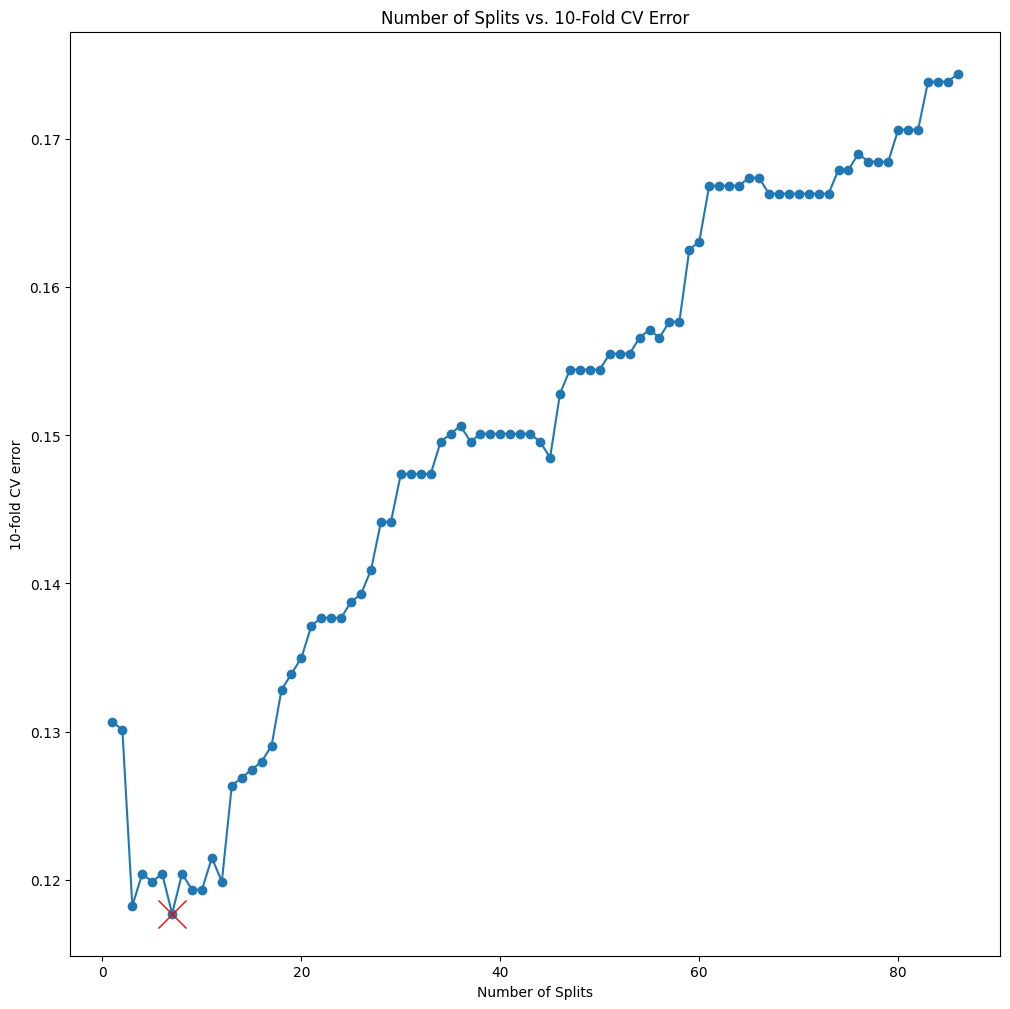

In [151]:
cv_df = pd.DataFrame(grid.cv_results_)
alpha_list = [alpha_dict['ccp_alpha'] for alpha_dict in cv_df['params']]
err_list = [1 - acc for acc in cv_df['mean_test_score']]
min_err = min(err_list)
min_ind = err_list.index(min_err)
best_alpha = alpha_list[min_ind]

plt.figure(figsize=(12,12))

plt.plot(alpha_list, err_list, marker='o')
plt.plot(best_alpha, min_err, marker='x', markersize=20, color='red')
plt.text(best_alpha+0.0005, min_err - 0.001, "alpha=" + str(best_alpha), fontsize=10, color='red')
plt.xlabel("Alpha Parameter"); plt.ylabel("10-fold CV error"); plt.title("Alpha Parameter vs. 10-Fold CV Error")
plt.savefig("fig2.png");
plt.show();


# Number of splits vs. CV error

plt.figure(figsize=(12,12))

plt.plot(range(1, len(err_list)+1), err_list[::-1], marker='o')
plt.plot(7, min_err, marker='x', markersize=20, color='red')
plt.xlabel("Number of Splits"); plt.ylabel("10-fold CV error"); plt.title("Number of Splits vs. 10-Fold CV Error")
plt.savefig("fig3.png");
plt.show();


# Plotting Baseline/Model Training/Test Error

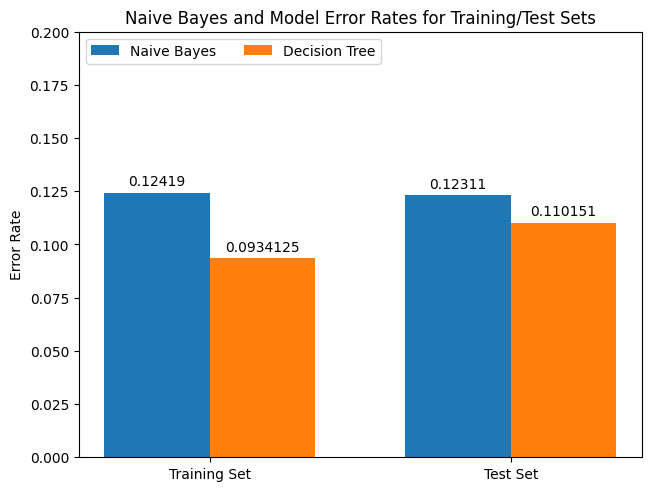

In [162]:
error_sets = ("Training Set", "Test Set")
errors = {
    'Naive Bayes': (err_bayes_train, err_bayes_test),
    'Decision Tree': (err_model_train, err_model_test)
}

x = np.arange(len(error_sets))
width = 0.35
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in errors.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error Rate')
ax.set_title('Naive Bayes and Model Error Rates for Training/Test Sets')
ax.set_xticks(x + width/2, error_sets)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.2)
fig.savefig("fig5.png")

plt.show()